# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


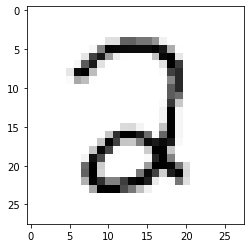

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2432
Training Accuracy: 0.6474, Testing Accuracy: 0.6562



Epoch 10, Loss 0.1331
Training Accuracy: 0.8865, Testing Accuracy: 0.9017



Epoch 20, Loss 0.0727
Training Accuracy: 0.9256, Testing Accuracy: 0.9370



Epoch 30, Loss 0.0523
Training Accuracy: 0.9444, Testing Accuracy: 0.9526



Epoch 40, Loss 0.0431
Training Accuracy: 0.9535, Testing Accuracy: 0.9582



Epoch 50, Loss 0.0382
Training Accuracy: 0.9567, Testing Accuracy: 0.9622



Epoch 60, Loss 0.0351
Training Accuracy: 0.9599, Testing Accuracy: 0.9632



Epoch 70, Loss 0.0329
Training Accuracy: 0.9619, Testing Accuracy: 0.9652



Epoch 80, Loss 0.0312
Training Accuracy: 0.9639, Testing Accuracy: 0.9667



Epoch 90, Loss 0.0298
Training Accuracy: 0.9653, Testing Accuracy: 0.9677



Epoch 100, Loss 0.0287
Training Accuracy: 0.9670, Testing Accuracy: 0.9703



Epoch 110, Loss 0.0277
Training Accuracy: 0.9677, Testing Accuracy: 0.9718



Epoch 120, Loss 0.0269
Training Accuracy: 0.9689, Testing Accuracy: 0.9713



Epoch 130, Loss 0.0261
Training Accuracy: 0.9698, Testing Accuracy: 0.9718



Epoch 140, Loss 0.0254
Training Accuracy: 0.9707, Testing Accuracy: 0.9723



Epoch 150, Loss 0.0248
Training Accuracy: 0.9717, Testing Accuracy: 0.9713



Epoch 160, Loss 0.0243
Training Accuracy: 0.9720, Testing Accuracy: 0.9718



Epoch 170, Loss 0.0238
Training Accuracy: 0.9730, Testing Accuracy: 0.9718



Epoch 180, Loss 0.0233
Training Accuracy: 0.9738, Testing Accuracy: 0.9718



Epoch 190, Loss 0.0228
Training Accuracy: 0.9739, Testing Accuracy: 0.9718



Epoch 200, Loss 0.0224
Training Accuracy: 0.9746, Testing Accuracy: 0.9728



Epoch 210, Loss 0.022
Training Accuracy: 0.9748, Testing Accuracy: 0.9728



Epoch 220, Loss 0.0216
Training Accuracy: 0.9755, Testing Accuracy: 0.9728



Epoch 230, Loss 0.0212
Training Accuracy: 0.9760, Testing Accuracy: 0.9733



Epoch 240, Loss 0.0209
Training Accuracy: 0.9763, Testing Accuracy: 0.9738



0.000992494893177091

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2713
Training Accuracy: 0.5372, Testing Accuracy: 0.5554



Epoch 10, Loss 0.1077
Training Accuracy: 0.8991, Testing Accuracy: 0.9057



Epoch 20, Loss 0.0811
Training Accuracy: 0.9236, Testing Accuracy: 0.9304



Epoch 30, Loss 0.0691
Training Accuracy: 0.9357, Testing Accuracy: 0.9446



Epoch 40, Loss 0.0621
Training Accuracy: 0.9412, Testing Accuracy: 0.9496



Epoch 50, Loss 0.0574
Training Accuracy: 0.9440, Testing Accuracy: 0.9531



Epoch 60, Loss 0.0539
Training Accuracy: 0.9468, Testing Accuracy: 0.9561



Epoch 70, Loss 0.0513
Training Accuracy: 0.9477, Testing Accuracy: 0.9577



Epoch 80, Loss 0.0492
Training Accuracy: 0.9492, Testing Accuracy: 0.9612



Epoch 90, Loss 0.0475
Training Accuracy: 0.9505, Testing Accuracy: 0.9632



Epoch 100, Loss 0.0461
Training Accuracy: 0.9514, Testing Accuracy: 0.9637



Epoch 110, Loss 0.0449
Training Accuracy: 0.9527, Testing Accuracy: 0.9647



Epoch 120, Loss 0.0438
Training Accuracy: 0.9534, Testing Accuracy: 0.9662



Epoch 130, Loss 0.0429
Training Accuracy: 0.9544, Testing Accuracy: 0.9672



Epoch 140, Loss 0.042
Training Accuracy: 0.9553, Testing Accuracy: 0.9672



Epoch 150, Loss 0.0413
Training Accuracy: 0.9561, Testing Accuracy: 0.9662



Epoch 160, Loss 0.0406
Training Accuracy: 0.9567, Testing Accuracy: 0.9667



Epoch 170, Loss 0.04
Training Accuracy: 0.9569, Testing Accuracy: 0.9667



Epoch 180, Loss 0.0395
Training Accuracy: 0.9572, Testing Accuracy: 0.9667



Epoch 190, Loss 0.0389
Training Accuracy: 0.9576, Testing Accuracy: 0.9667



Epoch 200, Loss 0.0385
Training Accuracy: 0.9580, Testing Accuracy: 0.9672



Epoch 210, Loss 0.038
Training Accuracy: 0.9584, Testing Accuracy: 0.9672



Epoch 220, Loss 0.0376
Training Accuracy: 0.9586, Testing Accuracy: 0.9672



Epoch 230, Loss 0.0372
Training Accuracy: 0.9591, Testing Accuracy: 0.9672



Epoch 240, Loss 0.0369
Training Accuracy: 0.9593, Testing Accuracy: 0.9677



0.04439885661602117

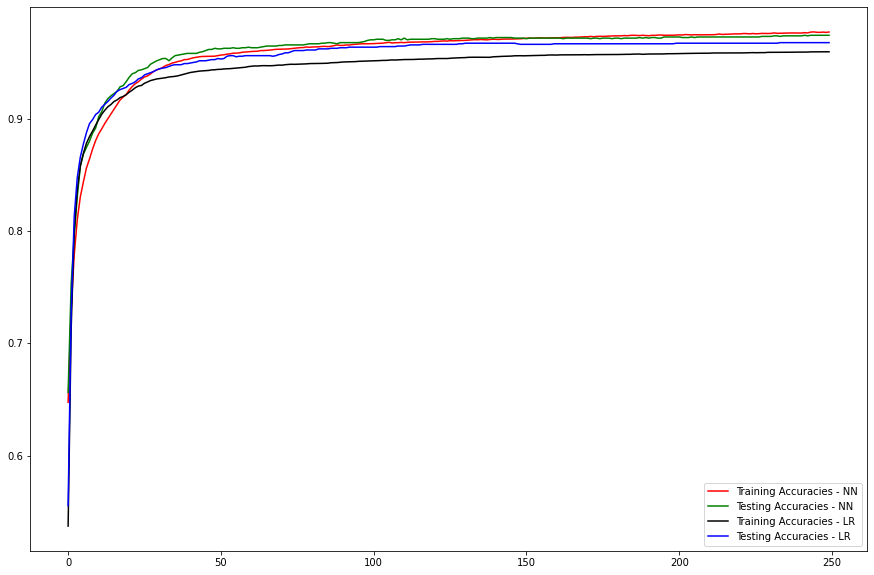

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

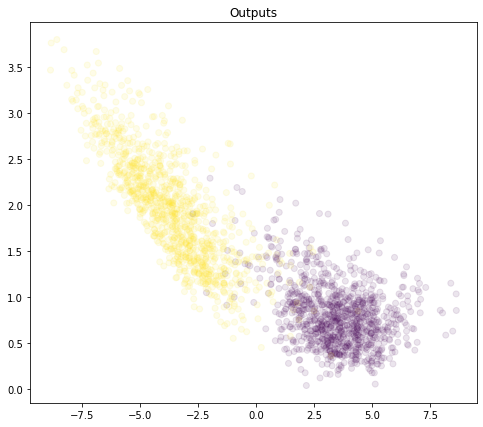

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

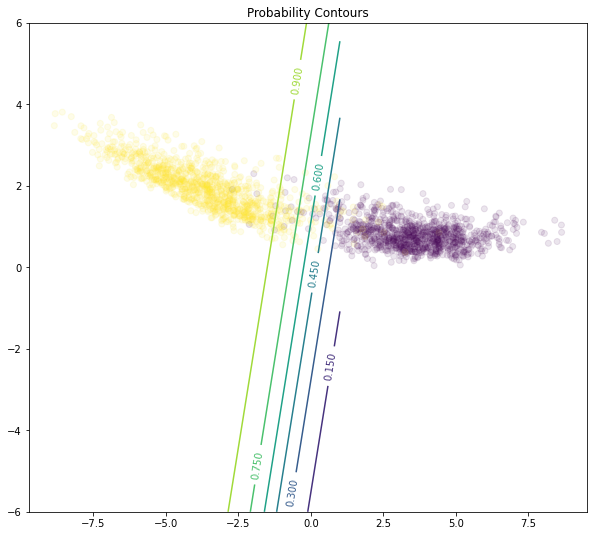

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );